<b><div style="color:red">COMMENTS:</div></b>

Check for comments in the notebook. If you have issues with the coding assignments, or if you get stuck, always feel free to reach out to me to discuss them, so that you can resolve them.

Also, if you receive help with the assignment, you are expected to report it.

# Hands-On Section (HW2)

### Read Carefully Before Proceeding

If you are having issues with running this code because of missing libraries, check the material that we've done in class for installation instructions. This code uses what we have already seen, so if you've been able to execute the code of the Notebooks we've seen in class, you will be fine here as well.


You need to answer all questions. Make sure that you answer both **technical** (code-related) and **non-technical** (conceptual) parts of this homework. A lot of code is already available for you, and you can build on that. You are free to use code from our notebooks in class.  All visualizations must be generated by your code, programmatically.


Once you're done, download the notebook via `File` -> `Download as` -> `Notebook`, which will fetch a file with an ".ipynb" extension. Include this file in your submission, as a separate document -- **not** in the word / pdf submission itself. In case you use additional code stored in another directory, make sure to submit that as well.

***


## Customer Churn

In this section, you will demonstrate your technical and other Data Science skills, when applied to the Customer Churn problem. MTC has given you access to a small subset of their data with information they have collected according to your specifications.

As such, they have provided two different datasets: a **training** ('churn_train.csv') and a **testing** one ('churn_test.csv'). You do not know how they picked which instances to place in the two files. Both datasets contain the same _features_ and they both have a target variable: whether the customer left or not. The target variable is the last "column" of the csv file(s), named `LEAVE`.


These two datasets are located within the `data/` folder. These are csv files, which you can open and have a look if interested. Nevertheless, the goal is to use your technical skills to address the problem.


Following good practices, import everything we'll need first. If you need to import more libraries, you can do so here.

In [15]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import datasets

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Let's read the two files. Pandas have a very convenient way to read CSV files.
train_orig = pd.read_csv('data/churn_train.csv')  # Start with the training dataset. 
test_orig = pd.read_csv('data/churn_test.csv')  # Proceed with the testing dataset.

In [6]:
# Let's print the first 10 rows of the training data to see what we got
train_orig.head(10)

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,PROFITABILITY,LEAVE
0,one,119070.0,25.0,17.0,179158.0,541.0,4.0,4.0,very_unsat,very_little,actively_looking_into_it,3.42,LEAVE
1,one,40157.0,53.0,0.0,972459.0,220.0,26.0,8.0,unsat,high,considering,5.35,STAY
2,zero,116959.0,211.0,0.0,245177.0,895.0,15.0,15.0,very_sat,very_little,actively_looking_into_it,3.51,LEAVE
3,one,21118.0,52.0,7.0,413655.0,205.0,3.0,5.0,very_sat,little,no,4.21,LEAVE
4,one,58114.0,154.0,50.0,258444.0,334.0,26.0,1.0,unsat,high,considering,3.14,LEAVE
5,one,54942.0,64.0,23.0,731897.0,306.0,5.0,5.0,very_unsat,high,actively_looking_into_it,6.60,STAY
6,zero,119820.0,155.0,0.0,863354.0,807.0,15.0,11.0,very_sat,avg,actively_looking_into_it,1.89,LEAVE
7,zero,107986.0,0.0,54.0,294067.0,601.0,4.0,2.0,sat,very_little,considering,5.67,LEAVE
8,one,117951.0,0.0,29.0,529357.0,344.0,0.0,1.0,unsat,very_little,actively_looking_into_it,7.16,LEAVE
9,zero,24079.0,0.0,0.0,928631.0,216.0,1.0,11.0,very_unsat,little,perhaps,5.37,STAY


### Preprocessing #1.1: Converting Features

Sklearn - our Python library for Machine Learning - implements the CART algorithm for Decision Trees.
That algorithm does not work with categorical or nominal features. If you try to use the algorithm as is, you will get errors.

We can address this problem by converting each of these categorical features to numerical ones, and this practice is quite common. But first, we need to find out which features we must convert.

In [7]:
train_orig.dtypes

COLLEGE                         object
INCOME                         float64
OVERAGE                        float64
LEFTOVER                       float64
HOUSE                          float64
HANDSET_PRICE                  float64
OVER_15MINS_CALLS_PER_MONTH    float64
AVERAGE_CALL_DURATION          float64
REPORTED_SATISFACTION           object
REPORTED_USAGE_LEVEL            object
CONSIDERING_CHANGE_OF_PLAN      object
PROFITABILITY                  float64
LEAVE                           object
dtype: object

From the output above, the values associated with "object" as a data type are the categorical ones.
For each of those categorical features, let's see their unique values.

In [8]:
# Go over the column names that are associated with "object" as shown above - i.e., categorical features -,
# and for each one of them show the unique values that it takes
for col_name in [ 'COLLEGE', 'REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL', 'CONSIDERING_CHANGE_OF_PLAN', 'LEAVE' ]:
    print( col_name, ": ", train_orig[col_name].unique() )

COLLEGE :  ['one' 'zero']
REPORTED_SATISFACTION :  ['very_unsat' 'unsat' 'very_sat' 'sat' 'avg']
REPORTED_USAGE_LEVEL :  ['very_little' 'high' 'little' 'avg' 'very_high']
CONSIDERING_CHANGE_OF_PLAN :  ['actively_looking_into_it' 'considering' 'no' 'perhaps' 'never_thought']
LEAVE :  ['LEAVE' 'STAY']


### Converting the feature values

Using the information that we see above, we will perform the following transformation / conversion on the features.

1. For the `COLLEGE` feature, we will map the values as follows: **'one'** = 1, **'zero'** = 0
2. For the `REPORTED_SATISFACTION`, we will map the values as follows: **'very_unsat'** = -2, **'unsat'** = -1, **'avg'** = 0, **'sat'** = 1, **'very_sat'** = 2
3. For the `REPORTED_USAGE_LEVEL`, we will map the values as follows: **'very_little'** = -2, **'little'** = -1, **'avg'** = 0, **'high'** = 1, **'very_high'** = 2
4. For the `CONSIDERING_CHANGE_OF_PLAN`, we will map the values as follows: **'no'** = -2, **'never_thought'** = -1, **'perhaps'** = 0, **'considering'** = 1, **'actively_looking_into_it'** = 2
5. For the `LEAVE`, we will map the values as follows: **'LEAVE'** = 1, **'STAY'** = 0

DataFrames provide a very convenient way to make such replacements. Assuming a variable `my_dframe` that points to a data frame, one may simply call the method `replace()` on that data frame, like so: `my_dframe.replace(...)`.

That method takes as input parameter the "rules" according to which the replacement will happen. These rules are given in the form of a dictionary. Each entry in that dictionary is a key value pair with the following semantics:
* key = column name
* value = { current_value1 : new_value1, current_value2 : new_value2, ... }

Take the `COLLEGE` column as an example. In that case, the key will be `COLLEGE` because that is the name of the column with values we want to modify. The _value_ corresponding to the `COLLEGE` key, will be _another_ dictionary. In that 2nd dictionary, the key is what we already have, e.g. `one`, or `zero`, and the value (of the dictionary) is what we want to change it to, i.e., `1` and `0`.
Putting it all together, for the `COLLEGE` example, we will have the following dictionary: `{'one' : 1, 'zero': 0}`.

The rule for just this column looks like this: `{"COLLEGE" : {"one" : 1, "zero": 0}}`.
The following piece of code shows all of the rules we must apply.


In [9]:
# create a dictionary mapping each string to a value
to_replace = {'COLLEGE':{'one':1,'zero':0},
           'REPORTED_SATISFACTION':{'very_unsat':-2,'unsat':-1,'avg':0,'sat':1,'very_sat':2},
           'REPORTED_USAGE_LEVEL':{'very_little':-2,'little':-1,'avg':0,'high':1,'very_high':2},
           'CONSIDERING_CHANGE_OF_PLAN':{'no':-2,'never_thought':-1,'perhaps':0,'considering':1,'actively_looking_into_it':2},
           'LEAVE':{'LEAVE':1,'STAY':0}
          }

The `replace()` method returns a new data frame where the modifications have already taken place.
We want to apply these transformations to **both** the train set **and** the test set.
The code below performs those changes.

In [10]:
# Apply the transformations to both the training and the testing dataset
train_data = train_orig.replace(to_replace)
test_data = test_orig.replace(to_replace)

In [11]:
# Check that the changes have been correctly applied
train_data.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,PROFITABILITY,LEAVE
0,1,119070.0,25.0,17.0,179158.0,541.0,4.0,4.0,-2,-2,2,3.42,1
1,1,40157.0,53.0,0.0,972459.0,220.0,26.0,8.0,-1,1,1,5.35,0
2,0,116959.0,211.0,0.0,245177.0,895.0,15.0,15.0,2,-2,2,3.51,1
3,1,21118.0,52.0,7.0,413655.0,205.0,3.0,5.0,2,-1,-2,4.21,1
4,1,58114.0,154.0,50.0,258444.0,334.0,26.0,1.0,-1,1,1,3.14,1


### Preprocessing #1.2: From DataFrame to _Features_ and _Labels_

The dataframe has everything together: our features of interest and the value for the target variable -- what we often call _"labels"_. As we've already seen, when training a model, our classifier expects the _features_ separately from the _labels_.

In the [fit()](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.fit) method, the first argument corresponds to the features only, while the labels (or target values) are the second argument.

For that reason, it is very convenient to separate the features from the labels for a given dataframe.

Implement a simple method below that is given a dataframe as input and returns 2 items: the first one will be the _features_ of the input dataframe, while the second one will be the _labels_ (column) of that dataframe.


In [12]:
print(list(train_data.keys())[:-1])

['COLLEGE', 'INCOME', 'OVERAGE', 'LEFTOVER', 'HOUSE', 'HANDSET_PRICE', 'OVER_15MINS_CALLS_PER_MONTH', 'AVERAGE_CALL_DURATION', 'REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL', 'CONSIDERING_CHANGE_OF_PLAN', 'PROFITABILITY']


In [13]:
# Implement the method, following the description above
# Given a dataframe, return the features and the labels (target variable values)

def separate_features_and_labels(dframe):
    variable_names = list(dframe.keys())[:-1]
    target_name = "LEAVE"
    
    features = dframe[variable_names]   # Your code here to get the features
    labels = dframe[target_name]   # Your code here to get the labels
    return features, labels  # This method returns the features and the labels in that order

In [14]:
# In case you want to test your method
X,Y=separate_features_and_labels(train_data)
print(X)
print("============================")
print(Y)

       COLLEGE    INCOME  OVERAGE  LEFTOVER     HOUSE  HANDSET_PRICE  \
0            1  119070.0     25.0      17.0  179158.0          541.0   
1            1   40157.0     53.0       0.0  972459.0          220.0   
2            0  116959.0    211.0       0.0  245177.0          895.0   
3            1   21118.0     52.0       7.0  413655.0          205.0   
4            1   58114.0    154.0      50.0  258444.0          334.0   
5            1   54942.0     64.0      23.0  731897.0          306.0   
6            0  119820.0    155.0       0.0  863354.0          807.0   
7            0  107986.0      0.0      54.0  294067.0          601.0   
8            1  117951.0      0.0      29.0  529357.0          344.0   
9            0   24079.0      0.0       0.0  928631.0          216.0   
10           1   29006.0    219.0      83.0  557407.0          162.0   
11           1   73329.0     52.0      43.0  430486.0          371.0   
12           0  111572.0      0.0      78.0  254936.0          8

## Deliverable #2: Accuracy and Cross-validation

For the following questions, train and (subsequently) use a Decision Tree classifier.
The classifier must use the `entropy` criterion to split.
For now, **do not** specify the `max_depth` parameter.


Following the above instructions, compute and report the following:
1. Classifier Accuracy on the training data <br/> <br/>

2. Classifier Accuracy on the test data <br/> <br/>

3. Classifier Average Accuracy of a **10-fold** cross-validation. Check the `cv` parameter of the `model_selection.cross_val_score()` method. <br/> <br/>

4. Train your classifier on 66% of the trainnig data and report the accuracy on the remaining 34%. Use the **numerical part** of your _NetID_ to randomize the instance selection process. Check the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method to do this step easily, and pay attention to the `random_state` parameter of that method.

<b><div style="color:red">COMMENTS:</div></b>

* In your `model_acc()`, `cv()` and `split_train()` methods, you have named the parameter `model`. To someone else who is reading your code (like me), this gives the impression you are talking about a machine learning model (e.g., a Decision Tree, a Logistic Regression model, etc). This isn't the case though. You are providing **data** upon which you'll train your model (your DecisionTree).


* Since you are already passing an integer for the `fold` parameter, there is no need to be doing `int(fold)`.


* To report the accuracy on the test set, you should be training on the features and labels coming from the `train_data` and then use the `predict()` and `metrics.accuracy_score()` methods on the `test_data`.


* When doing cross validation, you should only perform it on the `train_data` - this is how we perform cross-validation, in general. Assuming you wanted to treat both datasets together - not requested by the question and not how we use the train / test split in data mining projects, in general - you should first combine the two datasets into a single dataset and then apply Cross Validation on the big dataset.


* In the `split_train()` method implementation, you are doing `tree_clf.fit(X_test, Y_test)`, meaning that you are training your model on the 34% part of the `features` and `labels` and then using again that 34% to compute the accuracy.

Check the answer key for more details and how to approach this question. If the above do not make sense, come and see me.

In [33]:
def model_acc(model):
    features, labels = separate_features_and_labels(model)
    tree_clf = DecisionTreeClassifier(criterion="entropy")
    tree_clf.fit(features, labels)
    acc = metrics.accuracy_score(tree_clf.predict(features), labels)
    return acc
    
# Implement the following

# accuracy on the training data:
acc_train = model_acc(train_data)

# accuracy on the test data:
acc_test = model_acc(test_data)

# average (mean) accuracy on 10-fold CV:
def cv(model,fold):
    features, labels = separate_features_and_labels(model)
    tree_clf = DecisionTreeClassifier(criterion="entropy")
    tree_clf.fit(features, labels)
    return cross_val_score(tree_clf, features, labels, cv=int(fold))

acc_10cv = np.mean(cv(train_data,10)+cv(test_data,10))

# accuracy on 66% split:
def split_train(model):
    features, labels = separate_features_and_labels(model)
    X_train, X_test, Y_train, Y_test = train_test_split(features, labels, train_size=0.66, random_state=418)
    tree_clf = DecisionTreeClassifier(criterion="entropy")
    tree_clf.fit(X_test,Y_test)
    return metrics.accuracy_score(tree_clf.predict(X_test), Y_test)

acc_66pct = split_train(train_data)


print("accuracy on the training data : %.4f" % acc_train)
print("accuracy on the test data     : %.4f" % acc_test)
print("accuracy on the 10-fold CV    : %.4f" % acc_10cv)
print("accuracy on the 66%% split    : %.4f" % acc_66pct)


accuracy on the training data : 1.0000
accuracy on the test data     : 1.0000
accuracy on the 10-fold CV    : 1.2260
accuracy on the 66% split    : 1.0000


/Users/ashtsoi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Deliverable #2.1: Complexity Control

We've said in class that Decision Trees can overfit if we allow them to increase in depth a lot, and we should plot their performance (accuracy) as a function of their depth to figure out the "sweet spot".

We also mentioned that this classifier takes into account several other conditions, not just the depth, to check if they should split a region further. One such condition is the minimum number of instances we allow to appear in a leaf node. In sklearn's `DecisionTreeClassifier` this parameter is called `min_samples_leaf` and is specified when _creating_ the classifier, in a way similar to specifying the `max_depth` parameter. For more details check [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

For this deliverable, you will pick several different values (at least 5) for the depth of the tree and several different values (at least 4) for the minimum number of leaf instances. For each combination of (`max_depth`, `min_samples_leaf`) you will compute the average accuracy of a 3-fold cross validation.

You will then visualize, in the same plot, the different 3-fold average accuracy scores (y-axis) that you get as a function of the tree depth (x-axis). Each value of `min_samples_leaf` will be a separate line in the plot that you generate.

<br/>

**Requirements Checklist**
* Select several values (at least 5) for the maximum depth of the tree.
* Select several values (at least 4) for the minimum number of leaf instances
* For each combination of (max_depth, min_samples_leaf):
    * Do 3-fold cross validation (CV)
    * Compute the average accuracy of the 3-fold CV process. That's the accuracy score for this combination
* Visualize the computed information as follows:
    * The x axis must be the maximum tree depth values (in ascending order)
    * The y axis must be the accuracy score
    * Each value of minimum instances at a leaf needs to be a separate line in the plot

***


An easy way to generate the necessary values is through a **nested for-loop**.
We can then store these results in a DataFrame and plot them.
A simplified example is shown below:

Text(0, 0.5, 'This should be accuracy')

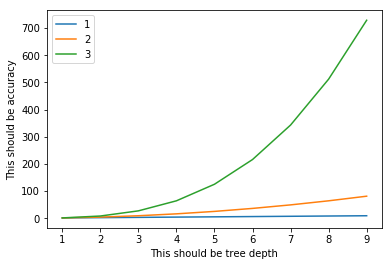

In [34]:
# Sample code that generates y-axis values for a given combination of 2 variables.
# This code is provided for convenience

xvals = range(1, 10)
line_vals = range(1, 4)

# We will use a dataframe because it has a simple-to-use plotting function.
sample_df = pd.DataFrame(index=xvals, columns=line_vals)

for v in line_vals:  # This loop controls the different lines
    l = []
    for x in xvals:  # This loop controls the different values on the x-axis
        l.append(x ** v)  # Simply compute x^v. Append in the list your value for the y-axis

    sample_df[v] = l  #Store the result to the dataframe for the particular line

# We can plot the contents of a dataframe with the plot() method
ax = sample_df.plot()
ax.set_xlabel("This should be tree depth")
ax.set_ylabel("This should be accuracy")

In [35]:
print(sample_df)

   1   2    3
1  1   1    1
2  2   4    8
3  3   9   27
4  4  16   64
5  5  25  125
6  6  36  216
7  7  49  343
8  8  64  512
9  9  81  729


The assignment asked that, given a combination of depth and minimum instances at a leaf, you will perform a 3-fold cross validation and compute the average score for that.

Things will be a lot easier if you create a method that:
* Takes the necessary input arguments
* Trains a DecisionTreeClassifier on the proper input
* Runs a 3-fold cross validation
* Computes the average accuracy of these 3 folds
* Returns the average accuracy

_Note:_ You do not have to structure your code this way if you do not want to, as long as you meet the objective.

<b><div style="color:red">COMMENTS:</div></b>

It'd be better to also pass the dataset you are training on as a parameter - that would be the `train_data` here. The reason is that your current implementation, there is an implicit dependency between what is happening inside the method and what is going on outside.

Also, for cross validation, there is no need to do `.fit()` on the model in advance. The `cross_val_score()` method will internally call the `fit()` for the proper splits / iterations of your data.

You can make things simpler and return the average value right away, instead of just returning the results of `cross_val_score()`.

In [36]:
# Your code here
# Think about the parameters that you will need for your code. Add them as arguments to your method
def cv_eval(depth,leaf):
    features, labels = separate_features_and_labels(train_data)
    tree_clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf, criterion="entropy")
    tree_clf.fit(features, labels)
    return cross_val_score(tree_clf, features, labels, cv=3)  # Return the proper value

Recall that you must select a number of depth levels and a number of minimum instances for the leaf nodes. You can then structure your code according to the sample code provided earlier.

You can then use the method that you created above to compute the average 3-fold Cross Validation accuracy score as your y-value for a given combination of parameters.

        1         10        50        100       150
1  0.644200  0.644200  0.644200  0.644200  0.644200
2  0.653733  0.653733  0.653733  0.653733  0.653733
3  0.678667  0.678667  0.678667  0.678667  0.678467
4  0.703867  0.703867  0.703800  0.703867  0.702400
5  0.705934  0.706068  0.706534  0.705601  0.704000
6  0.702134  0.702534  0.702134  0.701801  0.699534
7  0.699001  0.698401  0.702400  0.701534  0.698267
8  0.691267  0.692667  0.700667  0.700067  0.698267
9  0.685668  0.689401  0.695934  0.700201  0.698267


Text(0, 0.5, 'Accuracy')

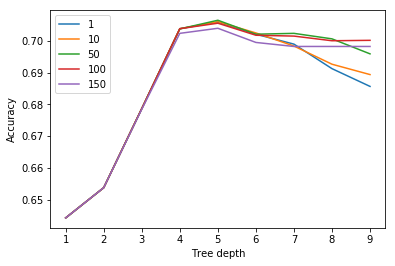

In [41]:
# Your code here

max_tree_depth = 10
leaf_instance = [1,10,50,100,150]
df = pd.DataFrame(index=range(1,int(max_tree_depth)), columns=leaf_instance)
for li in leaf_instance:  # This loop controls the different values on the x-axis
    scores=[]
    for td in range(1,int(max_tree_depth)):
        scores.append(np.mean(cv_eval(td,li)))
    df[li] = scores
print(df)

# We can plot the contents of a dataframe with the plot() method
ax = df.plot()
ax.set_xlabel("Tree depth")
ax.set_ylabel("Accuracy")

## Deliverable #2.2: Evaluation

Based on the graph that you generated above:
- What value would you use for max depth?
- What value would you use for min leaf size?
- If you could only specify one, which complexity parameter would you choose (max depth or min leaf size)? Why ?


### Answer

We can see from the graph that the accuracy increases as depth increases, but after depth 5, the accuracy of all models start to decrease. Therefore, we should use ***depth 5*** for the model. In terms of min leaf size, it is better to use somewhere ***around 50***, since the green line (model with 50 min leaf size) has the highest accuracy at tree depth 5.

If I were to only choose between specifying the tree depth or the leaf size, I would choose the ***tree depth***. This is because if we compare accross accuracy of models wih different tree depth, models with different tree depths vary significantly. However, it seems that no matter what minimum leaf size the model has, the accuracy does not vary as much. In other words, using minimum leaf size gives us less information gain in a way that using minimum leaf size to separate out the accuracy of the models does not decrease the entropy of each "categories" (e.g. low leaf size, medium leaf size, high leaf size, etc.) of models.
***


<b><div style="color:red">COMMENTS:</div></b>

Good answer overall!

Technically speaking, leaf size doesn't give "more" or "less" information gain. It implicitly allows or prevents the tree to grow deeper. Make sure you don't confuse those concepts. If the distinction is not clear, come and find me to discuss this.

Also, when you say "around 50", would you recommend that we pick 47 or 51? These values are also "around 50". Generally, "around 50" implies a "range" of values that we are allowed to pick, leading the others to think that you _actually tried_ those other values (around 50), and they gave consistent results.  Just keep this in mind for future reference.

## Deliverable #2.3: Test set Evaluation

Train a DecisionTreeClassifier using the parameters combination that produced the best result according to your complexity control evaluation. Report the accuracy of that classifier on the _test_ dataset, i.e. the 'churn_test.csv' dataset.

<b><div style="color:red">COMMENTS:</div></b>

As with the previous case, you are learning a model on some data and then computing the accuracy on the same data. This way, you are overestimating your model's performance.

Also, you have redefined a method that you already had: `model_acc()`. It's better to use an entirely new name, otherwise your earlier code may stop working.

In [15]:
# Show work here
def model_acc(model,depth,leaf):
    features, labels = separate_features_and_labels(model)
    tree_clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf, criterion="entropy")
    tree_clf.fit(features, labels)
    acc = metrics.accuracy_score(tree_clf.predict(features), labels)
    return acc

best_depth = 5
best_leaf_size = 50
acc_test = model_acc(test_data,best_depth,best_leaf_size)

print("Best Model Accuracy on the test data     : %.4f" % acc_test)


Best Model Accuracy on the test data     : 0.7094


## Deliverable #2.3: Learning Curves

Learning curves determine how much data you realistically need to train your model. You will be picking a portion of your original training data to train your model and then testing it on other datasets. In particular:

* Use the parameters that you picked as your best performing ones in your complexity control.
* Select multiple (at least 5, non-zero) percentage values. Each such percentage corresponds to how much of your original data you'll use for training.
* Use `train_test_split()` to select a percentage of the training data to use to fit the model
* Compute the accuracy on:
    * The train set that you got from the `train_test_split()` method.
    * 3-fold cross validation on the train set that you got from the split. You can / should reuse your method from before.
    * The test set that you got from the `train_test_split()` method.
    * The original testing dataset (the one that was given to us and is stored in 'data/churn_test.csv')
* Plot the accuracy (y-axis) as computed above VS train size (x-axis), for each of the 4 cases


Start by computing the above once for each percentage value. However, for a given percentage value, you should repeat these computations multiple times and report their average, to get more robust results.

<b><div style="color:red">COMMENTS:</div></b>

Basically, you've run into the problem that I pointed out earlier: you named your parameter "model" whereas it corresponds to the **data** that you are passing.  So, make sure that you pick names that minimize these kind of errors.

In addition, your most recent `model_acc()` method accepts 3 parameters which are:
1. The **data** (dataframe) to separate and train on
1. The **best max depth** to train the decision tree
1. The **best leaf size** to train the decision tree

In your code below, you are passing 3 entirely different parameters, which, of course, causes Python to complain.

First, you'll need to revisit some of the earlier comments, about what you are using to train your classifier and what you are using to measure the accuracy. Once you've corrected those, you can then use your code below by passing the right parameters.

If you get stuck with such issues, or even if you don't understand the comments I've made here, you are always welcome to come and see me to resolve them.

Also, check the answer key for more info.

In [19]:

# Your code here
splits = list(s/10 for s in range(10))
datas = ['train_data','cv','test_data','og']
df_lc = pd.DataFrame(index=splits, columns = datas)

tree_clf_lc = DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=best_leaf_size, criterion="entropy")

Xtest,Ytest = separate_features_and_labels(test_data)
Xtrain,Ytrain = separate_features_and_labels(train_data)
    
# Select the different training sizes
def acc(split):
    a = []
    X_train, X_test, Y_train, Y_test = train_test_split(Xtrain, Ytrain, test_size=split)
    tree_clf_lc.fit(X_train,Y_train)
    a.append(model_acc(tree_clf_lc,X_train,Y_train))
    a.append(np.mean(cross_val_score(tree_clf_lc,X_train,Y_train,cv=3)))
    a.append(model_acc(tree_clf_lc,X_test,Y_test))
    
    a.append(model_accuracy(tree_clf_lc,Xtest,Ytest))
    return a
# Write your code to generate the requested accuracy scores.
for s in splits:
    df_lc.loc[s] = acc(s)
print(df_lc)
# Make sure that you keep track of them so that you can visualize them.
plot_lc = df_lc.plot()
plot_lc.set_xlabel['Splits']
plot_lc.set_ylabel['Accuracy']

AttributeError: 'DecisionTreeClassifier' object has no attribute 'keys'

## Deliverable #3.1: Evaluation
Would you recommend your firm spend money to collect data on more customers?


### Answer

Your answer here

***